In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

2026-01-03 18:06:25.375440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767463585.626372      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767463585.700207      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767463586.262885      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767463586.262979      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767463586.262982      17 computation_placer.cc:177] computation placer alr

In [2]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(inputs)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides = 2)(x)

    return x

In [3]:
def decoder_block(inputs, skip_connections, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'valid')(inputs)
    skip_connections = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_connections)
    x = tf.keras.layers.Concatenate()([x, skip_connections])

    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [4]:
def unet_model(input_shape = (512, 512, 1), num_classes = 2):
    inputs = tf.keras.layers.Input(shape = input_shape)

    # Encoder
    s1 = encoder_block(inputs, 64)
    s2 = encoder_block(s1, 128)
    s3 = encoder_block(s2, 256)
    s4 = encoder_block(s3, 512)

    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(s4)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding = 'valid')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding = 'valid', activation = 'sigmoid')(d4)

    model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'U-Net')
    return model

In [5]:
unet = unet_model(input_shape = (512, 512, 1), num_classes = 2)
unet.summary()

2026-01-03 18:06:43.485762: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 510, 510,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 510, 510,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 255, 255,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 253, 253,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 253, 253,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 126, 126,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 124, 124,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 124, 124,  │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 62, 62,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 60, 60,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 60, 60,    │          0 │ conv2d_7[0][0]    │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ activation_7[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 28, 28,    │          0 │ conv2d_8[0][0]    │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 26, 26,    │  9,438,208 │ activation_8[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 26, 26,    │          0 │ conv2d_9[0][0]  

 Total params: 27,896,258 (106.42 MB)

 Trainable params: 27,896,258 (106.42 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


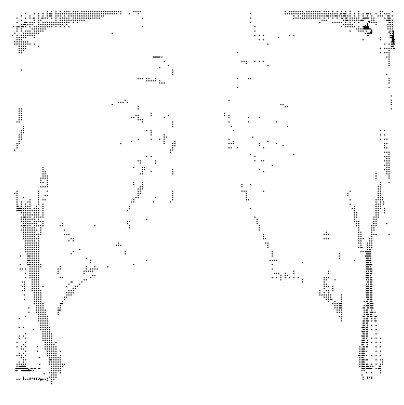

In [6]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img = Image.open('/kaggle/input/lung-mask-image-dataset/ChestXray/test/image/cxrimage_16932.png').convert('L')
img = img.resize((512, 512))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  

model = unet_model(input_shape=(512, 512, 1), num_classes=2)

predictions = model.predict(img_array)

pred_mask = np.squeeze(predictions, axis=0)
pred_mask = np.argmax(pred_mask, axis=-1).astype(np.uint8) * 255
pred_mask_img = Image.fromarray(pred_mask)
pred_mask_img = pred_mask_img.resize(img.size)

plt.figure(figsize=(5, 5))
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')
plt.show()

# pred_mask_img.save('predicted_image.jpg')
# pred_mask_img.show()